 <div style="text-align:center;">
  <span style="color:green; font-size:2em; font-weight:bold;">Modélisation</span><br><br>

# <span style="color:green">Introduction</span><br><br> 

### <span style="color:green">Références et équations de base de la relation d'Okun</span><br><br> 

Dans cette partie, nous allons proposer une modélisation permettant de vérifier empiriquement la loi d'Okun, à partir de la base de données "final_data", établie dans la partie "Préparation_données.ipynb".

La loi d'Okun, indique qu'à chaque fois que le PIB baisse d'un certain pourcentage par rapport à son potentiel, le taux de chômage tend à augmenter d'environ un point de pourcentage. Ainsi, une diminution du PIB réel est généralement associée à une augmentation du taux de chômage, comme décrit par Mankiw en 2003.

Pour cette modélisation, on s'inspire des travaux suivants : 

- [1]. Traoré, D. L., Diakite, S., & Mariko, O. (2021). Croissance et chômage au Mali : Vérification empirique de la loi d'Okun. Revue Malienne de Science et de Technologie, Série C : Sciences Humaines et Sociales, 02(25), Page. ISSN 1987-1031. CNRST, Bamako, Mali.

- [2]. Aassif, Z. L'extraction de la tendance cycle. Haut-Commissariat au Plan, Direction de la comptabilité nationale. 

- [3]. Mills, T. C. (2019). Chapter 12 - Transfer Functions and Autoregressive Distributed Lag Modeling. In Applied Time Series Analysis: A Practical Guide to Modeling and Forecasting (pp. 201-210). Loughborough University, Loughborough, United Kingdom. https://doi.org/10.1016/B978-0-12-813117-6.00012-0

Le travail [1] nous présente deux équations de base de la relation d'Okun, la version en "différences premières" et la "version gap".

- Version en "différences premières" : 
$$\Delta u = c + \beta\Delta \text{pib} + \epsilon$$

- "Version gap" : 
$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

avec $u$ le taux de chômage, $u^*$ le taux de chômage naturel, $\text{pib}^*$ le PIB potentiel et c, $\beta$ et $\epsilon$  des constantes à déterminer grâce à la modélisation. 

### <span style="color:green">Équation et outils utilisés dans notre modélisation</span><br><br> 

Pour la modélisation, nous allons utiliser la version "gap", qui relie le taux de chômage et le PIB de la manière suivante : 
**$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$**

Pour extraire la tendance à long terme du taux de chômage et du PIB (c'est-à-dire, le taux de chômage naturel et le PIB potentiel), à partir de la base de données, nous allons utiliser le filtre de **Hodrick-Prescott**. Ce filtre est introduit dans [2], et permet de décomposer une série selon sa tendance à long terme et son cycle (fluctuations autour de la tendance) à plus court terme.

Par ailleurs, pour prendre en compte la dynamique temporelle de nos données, nous allons utiliser le modèle **ARDL** (Auto Regressive Distributed Lag), introduit dans [2].

### <span style="color:green">Les différentes étapes de notre modélisation</span><br><br> 


**1. Clustering des Pays :**
Dans cette première étape, nous regroupons les pays présents dans la base de données selon des critères socio-économiques à l'aide de la technique du **clustering**.

**2. Sélection Aléatoire d'un pays par groupe :**
Au sein de chaque groupe formé lors du clustering, nous choisissons aléatoirement un pays afin d'assurer une représentation équitable.

**3. Modélisation de la Loi d'Okun avec ARDL :**
Nous allons utiliser le modèle ARDL pour modéliser la relation entre le taux de chômage et le PIB réel, et ce pour chacun des pays sélectionnés à l'étape précédente. La modélisation se présente les étapes suivantes :

- Prétraitement des séries temporelles :  nous commençons par différencier les séries des "gap" (écarts entre le taux de chômage naturel et réel, et entre le PIB potentiel et réel) jusqu'à ce qu'elles deviennent stationnaires. La stationnarité est cruciale pour assurer la stabilité des relations à long terme.

- Détermination des paramètres Lags : les paramètres lags nécessaires pour le modèle ARDL sont déterminés en utilisant les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF). Ces fonctions aident à identifier les retards significatifs à prendre en compte dans la modélisation.

- Régression OLS : Enfin, une régression OLS (Ordinary Least Squares) est appliquée en tenant compte des paramètres lags déterminés. Cela permet de modéliser la relation entre le taux de chômage et le PIB réel, en prenant en compte la dynamique temporelle. L'utilisation de la régression OLS dans le contexte de l'ARDL simplifie la modélisation tout en permettant une interprétation claire des paramètres.

# <span style="color:green"> I- Préparation des Dataframes</span><br><br> 

In [1]:
# Import nécessaire
import declarations as d 

In [2]:
# Importation de la base de données obtenue suite au nettoyage
data = d.pd.read_csv('bases/final_data.csv', encoding='latin-1')

In [3]:
# Visualisation
data.head(2)

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694


### <span style="color:green"> Base de données pour la modélisation</span><br><br> 

Pour la modélisation de la relation entre le PIB et le taux de chômage, nous aurons besoin de ces deux variables pour chaque pays en colonnes et des dates en indice. 

In [4]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_pivot = data.pivot(index=['YEAR'], columns='COUNTRY',
                    values=['Unemployment_rate', 'GDP_rate'])

# Ajuster les noms de colonnes
df_pivot.columns = [f'{col[1]}_{col[0].lower()}' for col in df_pivot.columns]

# Réinitialiser l'index pour avoir les colonnes YEAR et MONTH comme des colonnes régulières
df_pivot.reset_index(inplace=True)

# Renommer les colonnes (supprimer le suffixe _rate)
df_pivot = df_pivot.rename(columns=lambda x: x.replace('_rate', ''))

In [5]:
# Visualisation du nouveau dataframe
df_pivot.head(2)

,YEAR,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


### <span style="color:green"> Base de données pour le clustering </span><br><br> 

Pour le clustering, il nous faut une base de données avec en indice le nom des pays et en colonnes, les différents critères considérés, moyennés sur la période considérée.

In [6]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_cluster = data.pivot_table(index='COUNTRY', values=['Unemployment_rate', 'GDP_rate','life_expentancy',
       'pop_growth_rate'], aggfunc='mean')

In [7]:
# Visualisation
df_cluster.head(2)

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969


# <span style="color:green">II- Clustering : regroupement des pays selon des critères socio-économiques</span><br><br> 

Dans cette partie, le clustering nous permettra de tirer des groupes homogènes de pays. Quatres (4) critères sont retenus : 

<div style="margin-left: 20px;">
    <span style="font-weight:bold;">1.</span> Le PIB,<br>
    <span style="font-weight:bold;">2.</span> le taux de chômage,<br>
    <span style="font-weight:bold;">3.</span> l'espérance de vie, <br>
    <span style="font-weight:bold;">4.</span> et le taux de croissance de la population.
    </div>

Chaque variable étant moyennée sur la période considérée. 

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [9]:
# Supprimer les lignes ayant des valeurs manquantes
df_cluster.dropna(inplace=True)

In [10]:
# Visualisation 
df_cluster.head()

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969
BEL,0.913237,7.774560,79.483950,0.498965
BGR,0.799515,10.575434,72.878191,-0.792854
CAN,0.922738,7.485185,80.470733,1.032642


c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


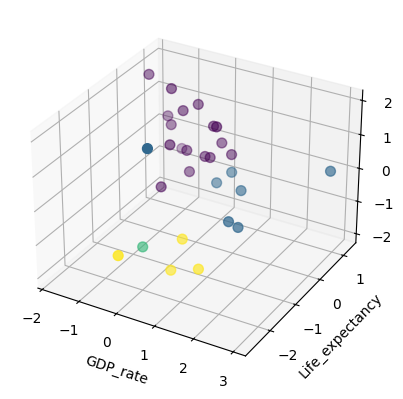

In [11]:
# Standardiser les données (important pour K-means)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Appliquer l'algorithme K-means
num_clusters = 4 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualisation en 3D (utilisant les variables GDP_rate, Life_expectance, Pop_growth_rate)
fig = d.plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:, 1], df_scaled[:, 2], df_scaled[:, 3], c=df_cluster['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('GDP_rate')
ax.set_ylabel('Life_expectancy')
ax.set_zlabel('Pop_growth_rate')
d.plt.show()

In [12]:
# Afficher les groupes et les pays
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    print(f'Cluster {cluster_num + 1}: {list(countries_in_cluster)}')

Cluster 1: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CZE', 'DEU', 'FRA', 'GBR', 'IRL', 'JPN', 'LUX', 'NOR', 'NZL', 'SGP', 'SWE', 'USA']
Cluster 2: ['ESP', 'FIN', 'PHL', 'POL', 'PRT', 'SVK', 'SVN']
Cluster 3: ['ROU']
Cluster 4: ['BGR', 'EST', 'LTU', 'RUS']


# <span style="color:green">III- Extraction de la tendance du taux de chômage et du PIB</span><br><br> 

## <span style="color:green">III-1. Base de données du taux de chômage pour chaque pays </span><br><br> 

In [13]:
# Extraire toutes les colonnes avec le suffixe "_rate" ainsi que la colonne des dates
columns_unemployment = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_unemployment')] 
df_unemployment = df_pivot[columns_unemployment]

# Définir la colonne 'YEAR' comme index 
df_unemployment.set_index('YEAR', inplace = True)

In [14]:
# Visualisation
df_unemployment.head(2)

,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,EST_unemployment,...,POL_unemployment,PRT_unemployment,ROU_unemployment,RUS_unemployment,SGP_unemployment,SVK_unemployment,SVN_unemployment,SWE_unemployment,URY_unemployment,USA_unemployment
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,7.600000,...,16.450000,7.756329,10.9,6.759498,1.750000,14.620000,14.650000,10.839335,12.100000,6.2
1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,7.466667,...,16.533333,7.916827,10.9,6.574419,1.666667,14.426667,14.966667,10.866990,12.083333,6.5


## <span style="color:green">III-2. Base de données du PIB réel pour chaque pays</span><br><br> 

In [15]:
# Extraire toutes les colonnes avec le suffixe "_gdp" ainsi que la colonne des dates
columns_gdp = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_gdp')] 
df_gdp = df_pivot[columns_gdp]

# Définir la colonne 'YEAR' comme index 
df_gdp.set_index('YEAR', inplace = True)

In [16]:
# Visualisation
df_gdp.head(2)

,AUS_gdp,AUT_gdp,BEL_gdp,BGR_gdp,CAN_gdp,CHE_gdp,CZE_gdp,DEU_gdp,ESP_gdp,EST_gdp,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,0.501645,0.779464,0.796550,0.559233,0.680429,0.907331,0.814153,0.794548,0.774291,0.525902,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1994-02,0.502208,0.783616,0.798246,0.559740,0.680180,0.909250,0.818056,0.796374,0.778426,0.534253,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


## <span style="color:green">III-3. Extraction de la tendance du PIB et du taux de chômage d'un pays </span><br><br> 


Dans cette partie, on définit une classe qui permet de tracer la tendance à long terme et les cycles à court terme des deux variables considérées. 

La méthode **df_gap()** de cette classe permet d'obtenir une série avec les valeurs de la différence entre la valeur réelle et la tendance des deux variables considérées, pour un pays considéré. 

In [17]:
class CountryData:
    def __init__(self, country_code, unemployment_data, gdp_data):
        """
        Initialize a CountryData instance.

        Parameters:
        - country_code (str): The country code.
        - unemployment_data (pd.Series): Time series data for unemployment rate.
        - gdp_data (pd.Series): Time series data for GDP rate.
        """
        
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']

    def plot_trend_cycle(self):
        """
        Plot the trend and cycle components for unemployment rate and GDP rate after applying the Hodrick-Prescott filter to the time series.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)

        # Plot the trend and cycle of unemployment rate
        d.plt.plot(x, label='Original series')
        d.plt.plot(trend_x, label='Trend')
        d.plt.plot(cycle_x, label='Cycle')
        d.plt.legend()
        d.plt.show()

        # Extraction de la tendance à long terme du PIB
        y = self.gdp_rate

        # Appliquer le filtre de Hodrick-Prescott 
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)

        # Plot the trend and cycle of the trend
        d.plt.plot(y, label='Originale series')
        d.plt.plot(trend_y, label='Trend')
        d.plt.plot(cycle_y, label='Cycle')
        d.plt.legend()
        d.plt.show()
        
    def df_gap(self):
        
        """
        Calculate the gap series for unemployment rate and GDP rate.

        Returns:
        - df_gap (pd.DataFrame): DataFrame containing the gap values.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)
    
        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)
    
        # Calculate the new series by removing the trend
        gap_unemployment = x - trend_x
        gap_gdp = y - trend_y

        # Create a DataFrame with the new series
        df_x = d.pd.DataFrame({'YEAR': x.index, 'gap_unemployment': gap_unemployment.values})
        df_y = d.pd.DataFrame({'YEAR': y.index, 'gap_gdp': gap_gdp.values})

        # Merge the DataFrames on the 'YEAR' column
        df_gap = d.pd.merge(df_x, df_y, on='YEAR', how='inner')

        return df_gap


# <span style="color:green">IV- Vérification de la loi pour un pays tiré aléatoirement dans chaque groupe</span><br><br>

## <span style="color:green">IV-1. Modèle ARDL : modélisation de la relation PIB/taux de chômage </span><br><br>

In [18]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

La classe qui suit permet d'effectuer le preprocessing des DataFrames contenant les valeurs "gap" du PIB et du taux de chômage. Elle comprend l'étape de différencitation afin d'obtenir des séries temporelles stationnaires ainsi que l'affichage des fonctions ACF et PACF en vu d'établir les retards significatifs lags. 

In [20]:
class PreProcessing:
    def __init__(self, country_code, unemployment_data, gdp_data):
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']
        self.country = CountryData(self.country_code, unemployment_data, gdp_data)
        self.unemployment_series = self.country.df_gap()['gap_unemployment']
        self.gdp_series = self.country.df_gap()['gap_gdp']

    def differentiation(self, series):
        # Différenciation des séries temporelles
        return series.diff().dropna()

    def stationarity_test(self, series, name):
        result = d.adfuller(series, autolag='AIC')
        #print(f'Test ADF pour la série {name}:')
        #print(f'ADF Statistic: {result[0]}')
        #print(f'p-value: {result[1]}')
        #print(f'Nombre de lags utilisés: {result[2]}')
        #print(f'Nombre d\'observations utilisées: {result[3]}')
        #print(f'Valeurs critiques:')
        #for key, value in result[4].items():
            #print(f'   {key}: {value}')

        p_value = result[1]
        i = 0
        diff_series = [series]
        while p_value > 0.05:
            diff_series.append(self.differentiation(diff_series[i]))
            result = d.adfuller(diff_series[i + 1], autolag='AIC')
            p_value = result[1]
            i += 1

        return diff_series[i]

    def ACF_PACF_plot(self):
        """Cette fonction permet d'afficher les graphiques de l'ACF et du PACF des séries stationnaires (obtenues après différenciation ou non).
        A partir de ces graphiques, nous allons pouvoir déterminer le nombre de retards significatifs à considérer pour chacune des séries."""
        
        diff_unemployment_series = self.stationarity_test(self.unemployment_series, 'Unemployment_rate')
        diff_gdp_series = self.stationarity_test(self.gdp_series, 'Real_GDP')

        df_diff = d.pd.DataFrame({
            'Unemployment_rate': diff_unemployment_series,
            'Real_GDP': diff_gdp_series
        })

        # Créer une figure et des axes pour les graphiques
        fig, axes = d.plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

        # ACF - Diff_Unemployment_rate
        plot_acf(df_diff['Unemployment_rate'], ax=axes[0, 0], lags=40, title='ACF - Unemployment_rate')

        # PACF - Diff_Unemployment_rate
        plot_pacf(df_diff['Unemployment_rate'], ax=axes[0, 1], lags=40, title='PACF - Unemployment_rate')

        # ACF - Diff_Real_GDP
        plot_acf(df_diff['Real_GDP'], ax=axes[1, 0], lags=40, title='ACF - Real_GDP')

        # PACF - Diff_Real_GDP
        plot_pacf(df_diff['Real_GDP'], ax=axes[1, 1], lags=40, title='PACF - Real_GDP')

        # Ajuster l'espacement entre les graphiques
        d.plt.tight_layout()

        # Afficher la figure
        d.plt.show()

La prochaine classe utilise la méthode OLS (Ordinary Least Squares) pour obtenir les résultats statistiques du modèle. L'OLS est une technique statistique utilisée pour estimer les paramètres d'une régression linéaire en minimisant la somme des carrés des écarts entre les valeurs observées et prédites. En modélisation économétrique et de séries temporelles, l'OLS est fréquemment utilisé pour estimer la relation linéaire entre une variable dépendante et des variables explicatives. 

Les modèles ARDL (AutoRegressive Distributed Lag), quant à eux, prennent en compte les retards des variables. L'utilisation de la méthode OLS, intégrant des retards, permet de modéliser des relations ARDL, intégrant la dynamique temporelle des séries temporelles, une approche courante en économétrie, que nous utilisons dans notre modélisation.

Dans le code, les retards des variables explicatives (Unemployment_rate et Real_GDP) sont inclus en créant des colonnes décalées dans la matrice d'observations. 


In [80]:
class ARDLAnalysis:
    def __init__(self, country_code, unemployment_data, gdp_data, lags_ur, lags_gdp):
        self.country_code = country_code
        self.lags_ur = lags_ur
        self.lags_gdp = lags_gdp
        self.unemployment_series, self.gdp_series = self.preprocess_data(unemployment_data, gdp_data)

    def preprocess_data(self, unemployment_data, gdp_data):
        preprocessing = PreProcessing(self.country_code, unemployment_data, gdp_data)
        return preprocessing.stationarity_test(preprocessing.unemployment_series, 'Unemployment_rate'), \
               preprocessing.stationarity_test(preprocessing.gdp_series, 'Real_GDP')


    def create_explanatory_matrix(self):
        df_diff = d.pd.DataFrame({
            'Unemployment_rate': self.unemployment_series,
            'Real_GDP': self.gdp_series
        })
        self.df_diff = df_diff
        for lag in range(1, max(self.lags_ur, self.lags_gdp) + 1):
            df_diff[f'Unemployment_rate_{lag}'] = df_diff['Unemployment_rate'].shift(lag)
            df_diff[f'Real_GDP_{lag}'] = df_diff['Real_GDP'].shift(lag)

        df_diff = df_diff.dropna()

        x = sm.add_constant(df_diff[['Unemployment_rate']])
        for lag in range(1, max(self.lags_ur, self.lags_gdp) + 1):
            x[f'Unemployment_rate_{lag}'] = df_diff[f'Unemployment_rate_{lag}']
            x[f'Real_GDP_{lag}'] = df_diff[f'Real_GDP_{lag}']

        return x

    def define_dependent_variable(self):
        y = self.df_diff['Real_GDP'].shift(-1).dropna()
        return y[y.index.isin(self.x.index)]

    def fit_ardl_model(self):
        self.x = self.create_explanatory_matrix()
        self.y = self.define_dependent_variable()

        # Vérifier que les deux dataframes ont bien les mêmes données
        Y = self.y[self.y.index.isin(self.x.index)]
        X = self.x[self.x.index.isin(Y.index)]

        # Ajuster le modèle ARDL
        model = sm.OLS(Y, X)
        results = model.fit()

        # Afficher les résultats
        return results.summary()

## <span style="color:green">IV-2.  Application du modèle à un pays sélectionné aléatoirement pour chaque cluster </span><br><br>

### <span style="color:green">IV.2.1. Tirage aléatoire d'un pays dans chaque cluster </span><br><br>

In [42]:
# Afficher le pays sélectionné de manière aléatoire dans chaque cluster
list_random_countries = []
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    random_country = d.np.random.choice(countries_in_cluster)
    list_random_countries.append(random_country)
    print(f'Cluster {cluster_num + 1}: {random_country}')

Cluster 1: JPN
Cluster 2: POL
Cluster 3: ROU
Cluster 4: EST


### <span style="color:green">IV.2.2. Pays du cluster 1  </span><br><br>

Nous allons détailler la méthode pour le pays du premier cluster, méthode que nous utiliserons pour les autres pays. 

Tout d'abord, il faut savoir que la stationnarité est une condition importante pour l'application de modèles ARDL. L'étape de préprocessing va donc permettre de vérifier si les séries Unemployment_rate et Real_GDP sont stationnaires et de les différencier jusqu'à l'obtention de séries stationnaires, le cas contraire.

Unemployment_rate contient les valeurs de la différence entre le taux de chômage réel et sa tendance.
Real_GDP contient les valeurs de la différence entre le PIB réel et sa tendance.

Par ailleurs, après obtention de séries stationnaires, nous souhaitons déterminer le nombre approprié de retards significatifs (lags) à considérer dans notre modèle pour chacune des séries. Pour cela, nous pouvons nous servir des graphiques de la fonction d'autocorrélation (ACF) et de la fonction d'autocorrélation partielle (PACF). Ces graphiques aident à visualiser les corrélations entre les observations à différents retards. Nous devons rechercher des retards significatifs où les corrélations sont en dehors de l'intervalle de confiance.

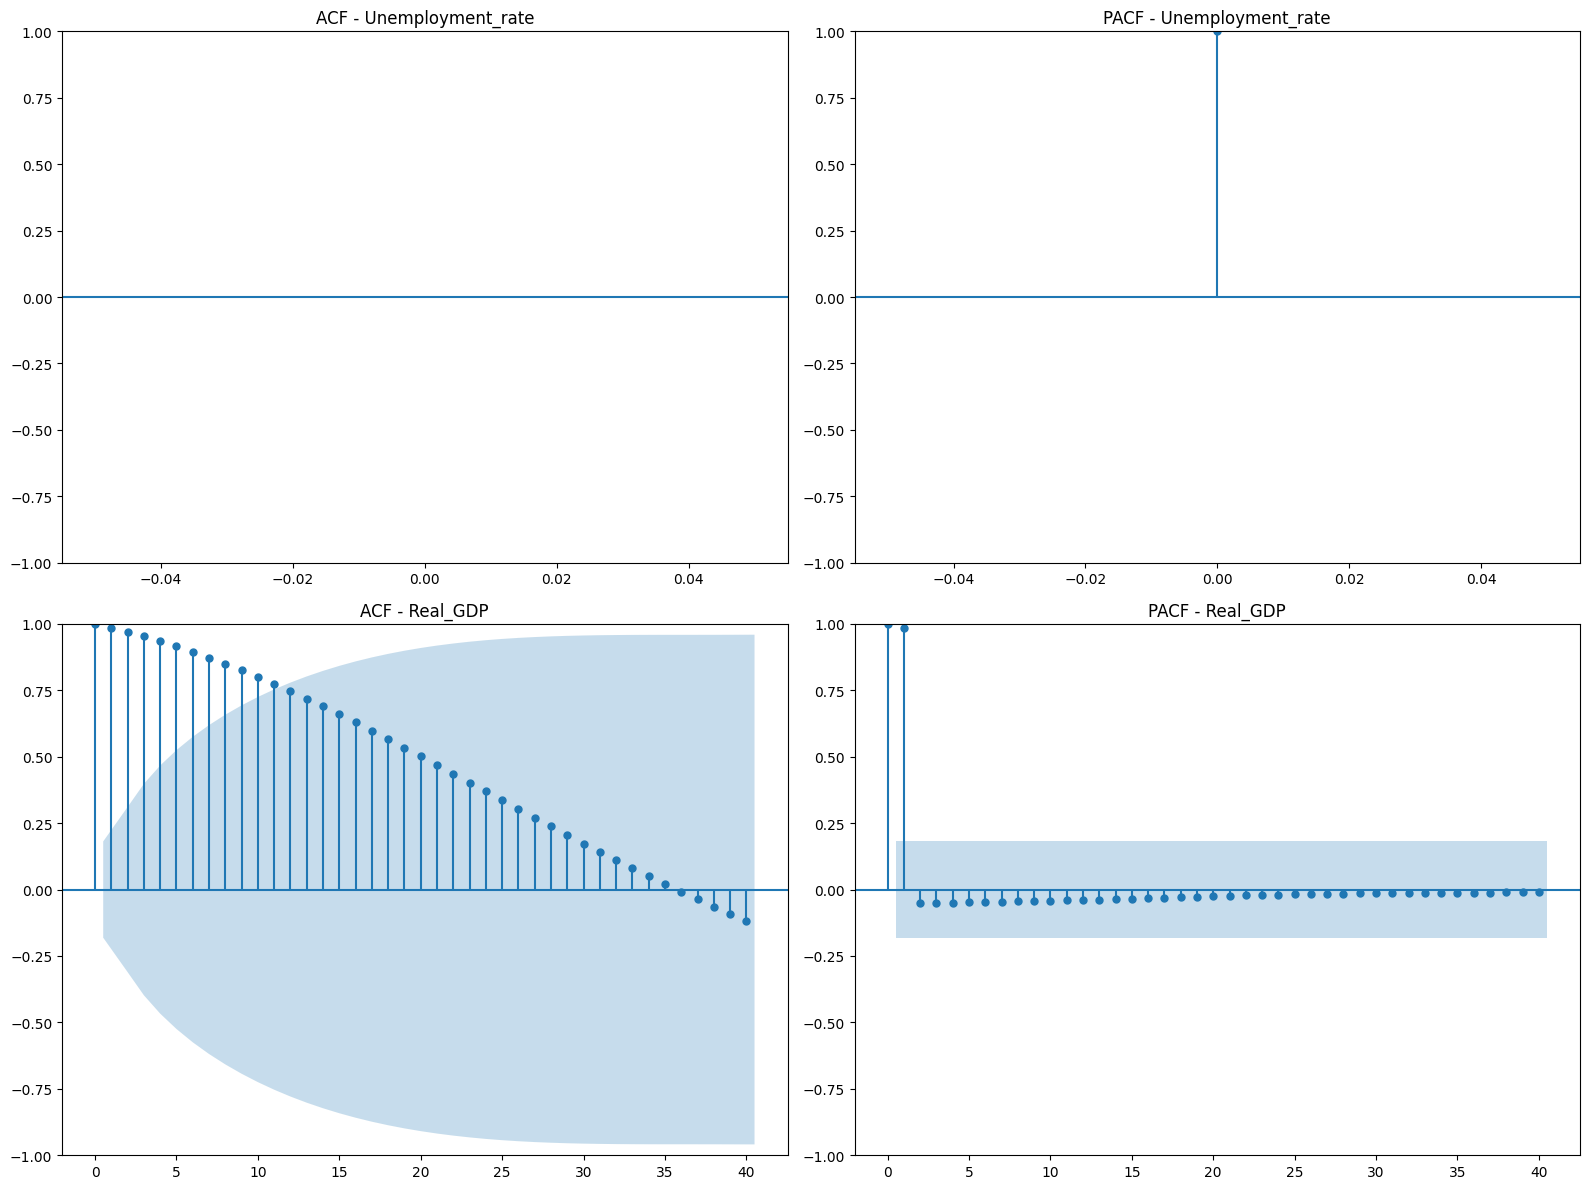

In [43]:
# Etape de préprocessing et d'affichage des fonctions ACF et PACF
country_code1 = list_random_countries[0]
country1 = PreProcessing(country_code1, df_unemployment, df_gdp)
country1.ACF_PACF_plot()

En observant les graphiques, le lecteur doit définir les lags appropriés dans la cellule code qui suit. Pour cela, il faut compter le nombre de pics en dehors de l'intervalle de confiance des graphes ACF et PACF et retenir le nombre maximal entre les deux, et ce, pour chacune des variables "Unemployment_rate" et "Real_GDP".

N.B. Si l'ACF et le PACF sont nuls sauf pour un nombre fini de points, il faut prendre un nombre de lags nul.

In [61]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_1 = 5  # Lags pour Unemployment_rate
lags_gdp_1 = 0  # Lags pour Real_GDP

La cellule code qui suit, nous permet d'obtenir les résultats de la modélisation. 

N.B. Le modèle utilisé est une spécification simple d'un modèle ARDL (AutoRegressive Distributed Lag), qui utilise la régression OLS. La dynamique temporelle est partiellement prise en compte dans la mesure où le modèle inclut un lag du taux de chômage (Unemployment_rate) pour capturer l'effet retardé sur la variable dépendante (Real_GDP).

In [81]:
# Affichage des résultats de la modélisation
country1_model = ARDLAnalysis(country_code1, df_unemployment, df_gdp, lags_ur_1, lags_gdp_1)
country1_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.328e+08
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:12:45   Log-Likelihood:                 1109.5
No. Observations:                 108   AIC:                            -2195.
Df Residuals:                      96   BIC:                            -2163.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0002   3.57e-05      4.701      0.000    9.71e-05       0.000
Unemployment_rate       0.0164      0.012      1.332      0.186      -0.008       0.041
Unemployment_rate_1    -0.0436      0.024     -1.814      0.073      -0.091       0.004
Real_GDP_1             11.6775      0.420     27.772      0.000      10.843      12.512
Unemployment_rate_2     0.0386      0.025      1.515      0.133      -0.012       0.089
Real_GDP_2            -27.3901      1.632    -16.781      0.000     -30.630     -24.150
Unemployment_rate_3    -0.0268      0.025     -1.057      0.293      -0.077       0.024
Real_GDP_3             27.0113      2.394     11.284      0.000      22.260      31.763
Unemployment_rate_4     0.0304      0.024      1.274      0.206      -0.017       0.078
Real_GDP_4            -12.5658      1.572     -7.991      0.000     -15.687      -9.444
Unemployment_rate_5    -0.0213      0.012     -1.768      0.080      -0.045       0.003
Real_GDP_5              2.2669      0.390      5.806      0.000       1.492       3.042
==============================================================================
Omnibus:                        2.942   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                2.415
Skew:                           0.351   Prob(JB):                        0.299
Kurtosis:                       3.211   Cond. No.                     9.93e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.04e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Interprétation**

En fonction du pays tiré aléatoirement, les résultats du modèle seront différents. Toutefois, voici quelques éléments qui permettront de voir si les résultats sont concluants ou non. 

- **R-squared** : Un R-squared élevé (proche de 1) suggère que le modèle explique une grande partie de la variabilité de la variable dépendante. Dans notre modélisation, un R-squared élevé (proche de 1) suggère que les séries considérées sont cointégrées, c'est-à-dire qu'il existe une combinaison linéaire de ces séries qui est stable à long terme. 

- **Coefficients** : 

    - Interprétation : Les coefficients associés à chaque variable explicative reflètent la relation linéaire entre cette variable et la variable dépendante.

    - Signification : Les coefficients significatifs (p-value < 0.05) indiquent que la variable a une influence statistiquement significative sur la variable dépendante. Un coefficient négatif suggère une relation inverse, tandis qu'un coefficient positif suggère une relation directe.

- **Dynamique temporelle** : 

    - Interprétation : Les termes de retard (lags) capturent comment les valeurs passées des variables influent sur la variable dépendante. 

    - Signification : La présence de lags peut indiquer une dépendance temporelle, soulignant l'importance des valeurs passées dans la prédiction de la variable actuelle.

- **p-values** : 

    - Interprétation : Les p-values associées à chaque coefficient testent l'hypothèse nulle selon laquelle le coefficient est égal à zéro.

    - Signification : Une p-value faible (généralement < 0.05) suggère que vous pouvez rejeter l'hypothèse nulle, ce qui indique que le coefficient est significativement différent de zéro.

Nous réitérons la même méthode pour les autres pays sélectionnés.

### <span style="color:green">IV.2.3. Pays du cluster 2  </span><br><br>

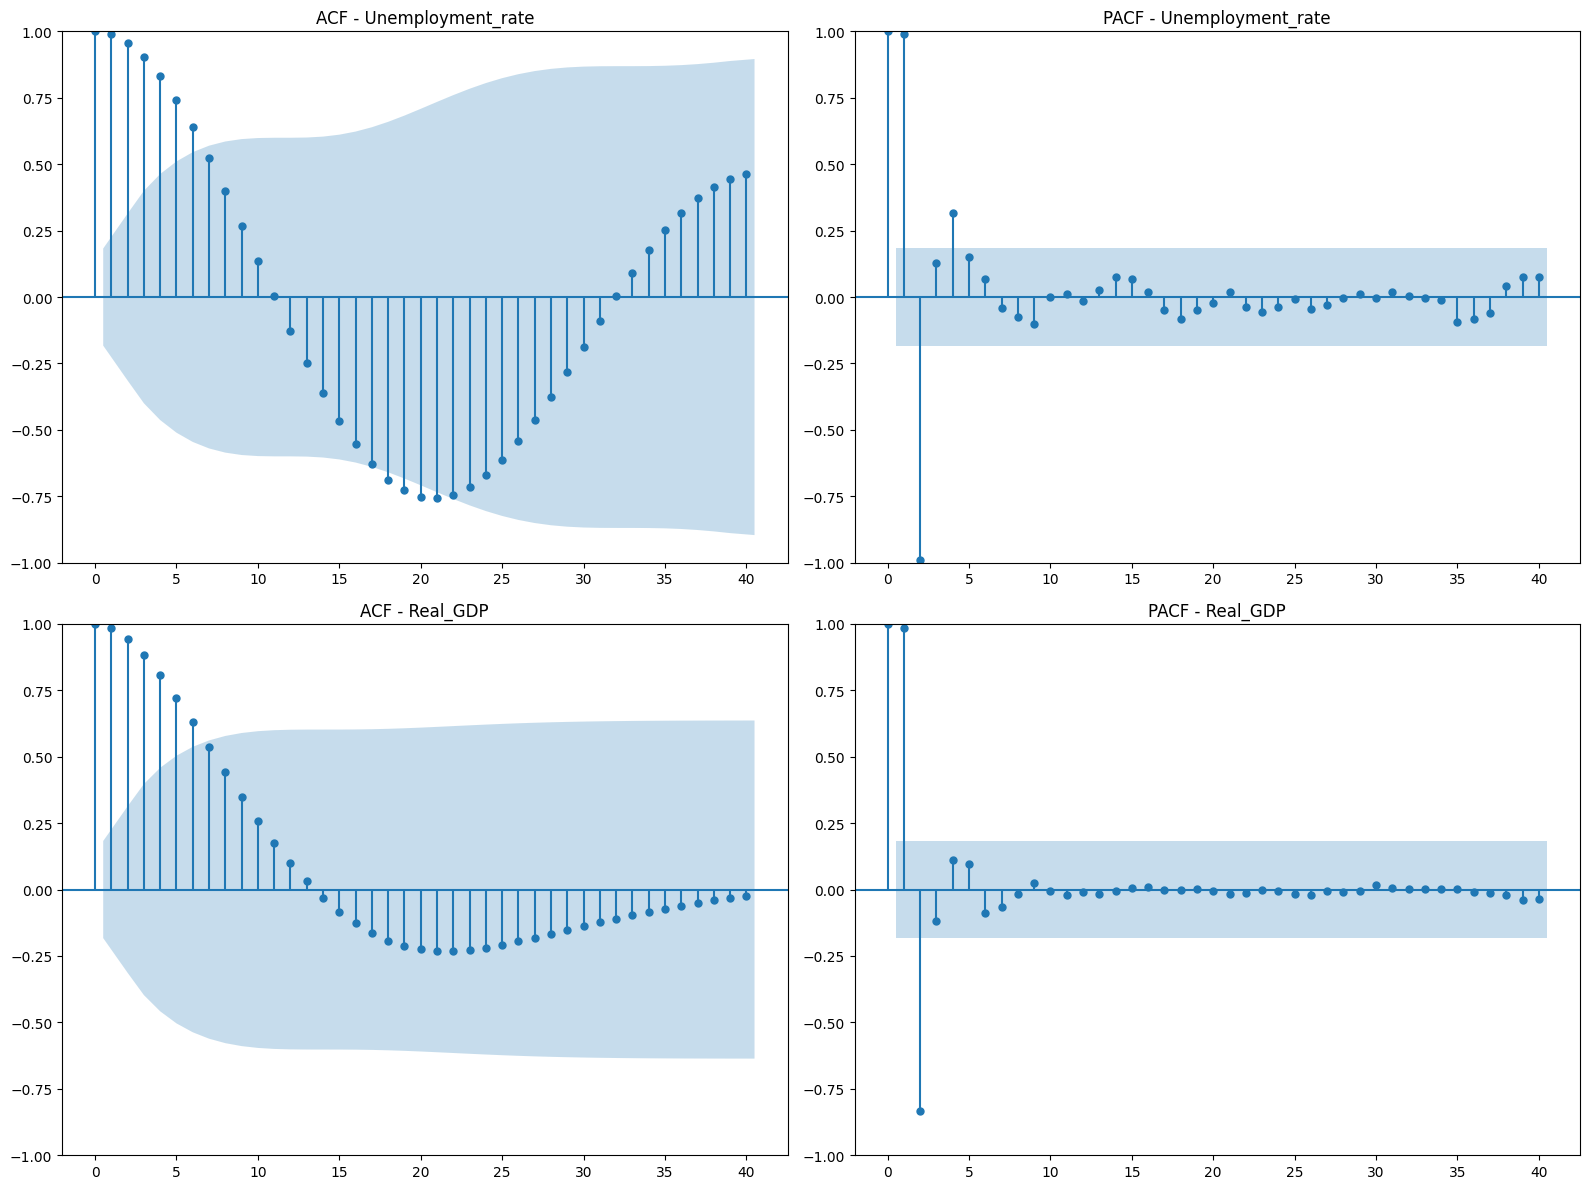

In [47]:
# Etape de préprocessing et d'affichage des fonctions ACF et PACF
country_code2 = list_random_countries[1]
country2 = PreProcessing(country_code2, df_unemployment, df_gdp)
country2.ACF_PACF_plot()

In [48]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_2 = 7  # Lags pour Unemployment_rate
lags_gdp_2 = 7  # Lags pour Real_GDP

In [82]:
# Affichage des résultats de la modélisation
country2_model = ARDLAnalysis(country_code1, df_unemployment, df_gdp, lags_ur_2, lags_gdp_2)
country2_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.345e+08
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:14:41   Log-Likelihood:                 1093.3
No. Observations:                 106   AIC:                            -2155.
Df Residuals:                      90   BIC:                            -2112.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0002   4.43e-05      4.648      0.000       0.000       0.000
Unemployment_rate       0.0202      0.012      1.653      0.102      -0.004       0.044
Unemployment_rate_1    -0.0469      0.024     -1.969      0.052      -0.094       0.000
Real_GDP_1             11.1062      0.490     22.660      0.000      10.133      12.080
Unemployment_rate_2     0.0333      0.026      1.303      0.196      -0.017       0.084
Real_GDP_2            -25.1068      2.159    -11.630      0.000     -29.396     -20.818
Unemployment_rate_3    -0.0250      0.026     -0.970      0.335      -0.076       0.026
Real_GDP_3             23.9419      4.175      5.735      0.000      15.648      32.236
Unemployment_rate_4     0.0242      0.026      0.939      0.350      -0.027       0.076
Real_GDP_4            -11.8774      5.006     -2.373      0.020     -21.823      -1.932
Unemployment_rate_5    -0.0074      0.026     -0.288      0.774      -0.058       0.043
Real_GDP_5              4.3411      4.160      1.044      0.299      -3.924      12.606
Unemployment_rate_6     0.0095      0.024      0.400      0.690      -0.038       0.057
Real_GDP_6             -1.9257      2.099     -0.917      0.361      -6.096       2.245
Unemployment_rate_7    -0.0167      0.012     -1.367      0.175      -0.041       0.008
Real_GDP_7              0.5204      0.459      1.134      0.260      -0.391       1.432
==============================================================================
Omnibus:                        2.361   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.307   Jarque-Bera (JB):                1.780
Skew:                           0.226   Prob(JB):                        0.411
Kurtosis:                       3.447   Cond. No.                     2.68e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.27e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### <span style="color:green">IV.2.4. Pays du cluster 3  </span><br><br>

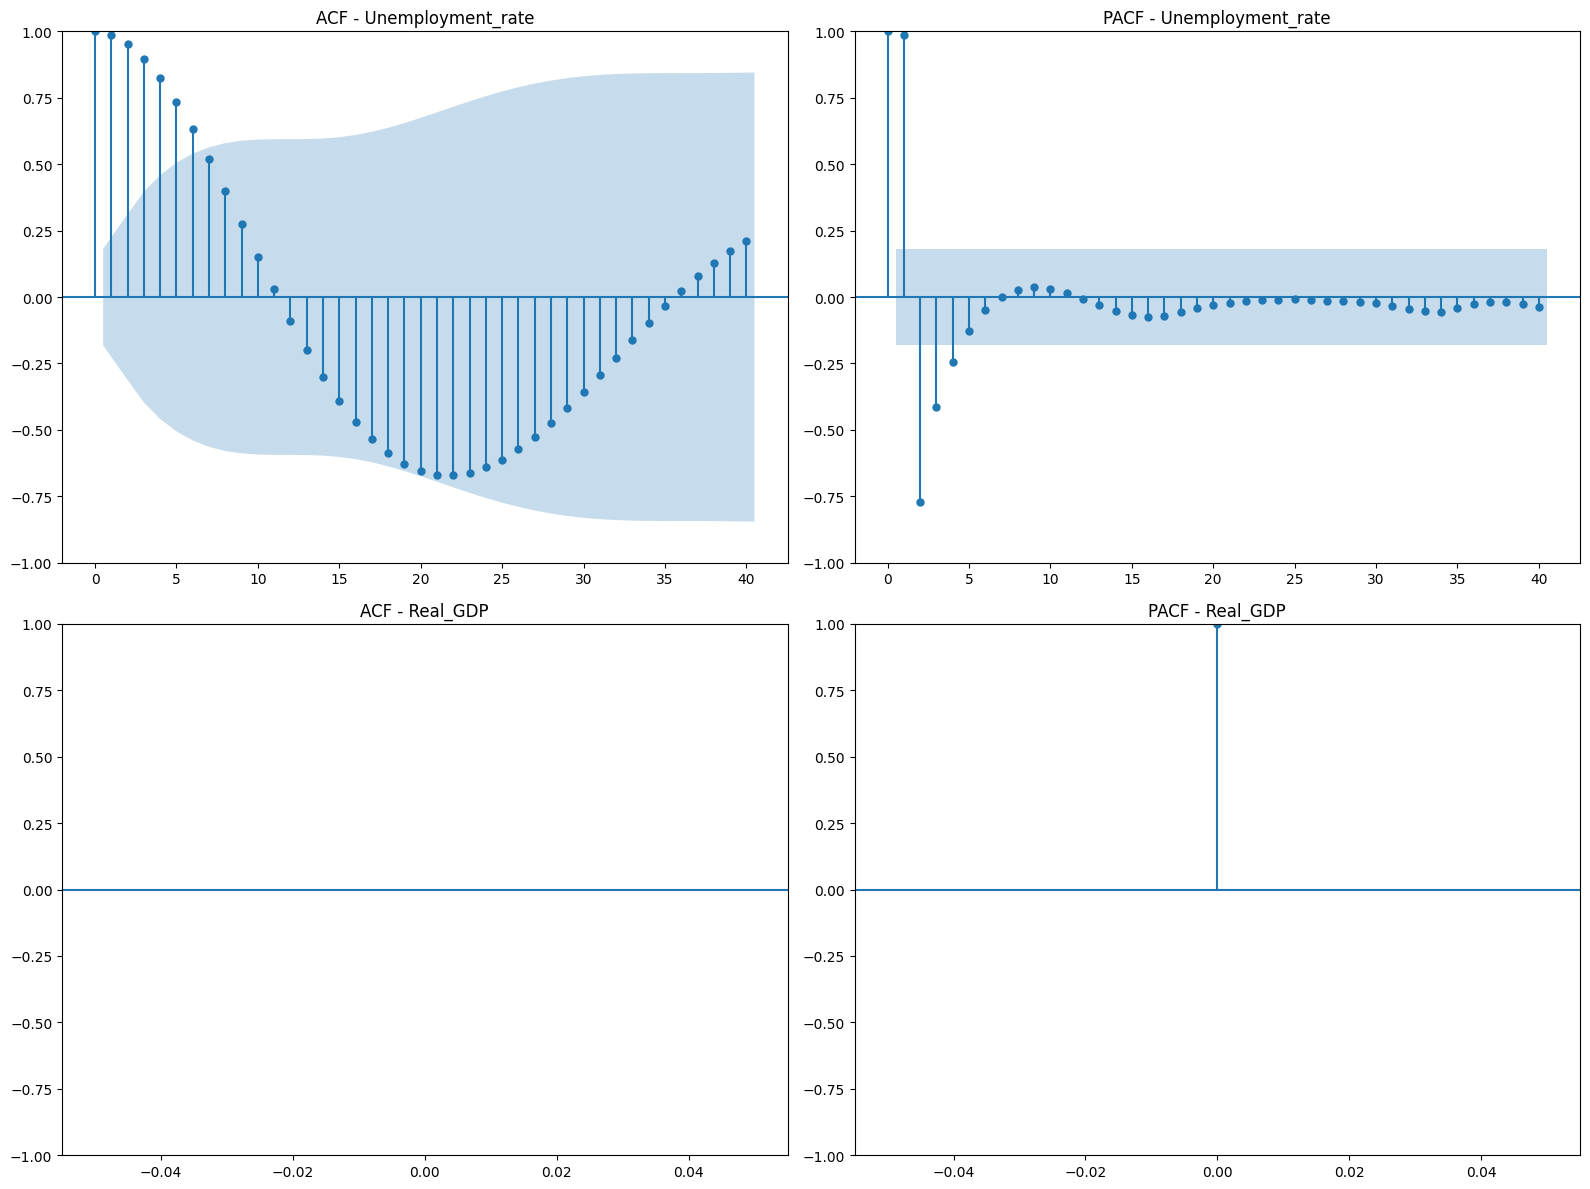

In [38]:
# Etape de préprocessing et d'affichage des fonctions ACF et PACF
country_code3 = list_random_countries[2]
country3 = PreProcessing(country_code3, df_unemployment, df_gdp)
country3.ACF_PACF_plot()

In [39]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_3 = 7  # Lags pour Unemployment_rate
lags_gdp_3 = 0  # Lags pour Real_GDP

In [83]:
# Affichage des résultats de la modélisation
country3_model = ARDLAnalysis(country_code3, df_unemployment, df_gdp, lags_ur_3, lags_gdp_3)
country3_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     57.45
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           2.14e-39
Time:                        19:14:52   Log-Likelihood:                 844.03
No. Observations:                 106   AIC:                            -1656.
Df Residuals:                      90   BIC:                            -1613.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.911e-05   2.26e-05      2.171      0.033    4.16e-06    9.41e-05
Unemployment_rate       0.0129      0.044      0.294      0.769      -0.074       0.100
Unemployment_rate_1    -0.0444      0.163     -0.271      0.787      -0.369       0.280
Real_GDP_1              1.5073      0.189      7.968      0.000       1.131       1.883
Unemployment_rate_2     0.0540      0.268      0.202      0.841      -0.477       0.585
Real_GDP_2             -0.8216      0.335     -2.452      0.016      -1.487      -0.156
Unemployment_rate_3     0.0434      0.283      0.153      0.879      -0.520       0.606
Real_GDP_3              0.4263      0.348      1.223      0.224      -0.266       1.119
Unemployment_rate_4    -0.2117      0.276     -0.767      0.445      -0.760       0.337
Real_GDP_4              0.0923      0.334      0.277      0.783      -0.571       0.756
Unemployment_rate_5     0.2698      0.252      1.069      0.288      -0.232       0.771
Real_GDP_5             -0.3206      0.245     -1.309      0.194      -0.807       0.166
Unemployment_rate_6    -0.1699      0.151     -1.126      0.263      -0.470       0.130
Real_GDP_6             -0.0617      0.209     -0.295      0.769      -0.477       0.354
Unemployment_rate_7     0.0467      0.039      1.183      0.240      -0.032       0.125
Real_GDP_7             -0.0273      0.119     -0.229      0.820      -0.264       0.210
==============================================================================
Omnibus:                       23.026   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.101
Skew:                          -0.697   Prob(JB):                     4.43e-15
Kurtosis:                       6.609   Cond. No.                     6.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <span style="color:green">IV.2.5. Pays du cluster 4  </span><br><br>

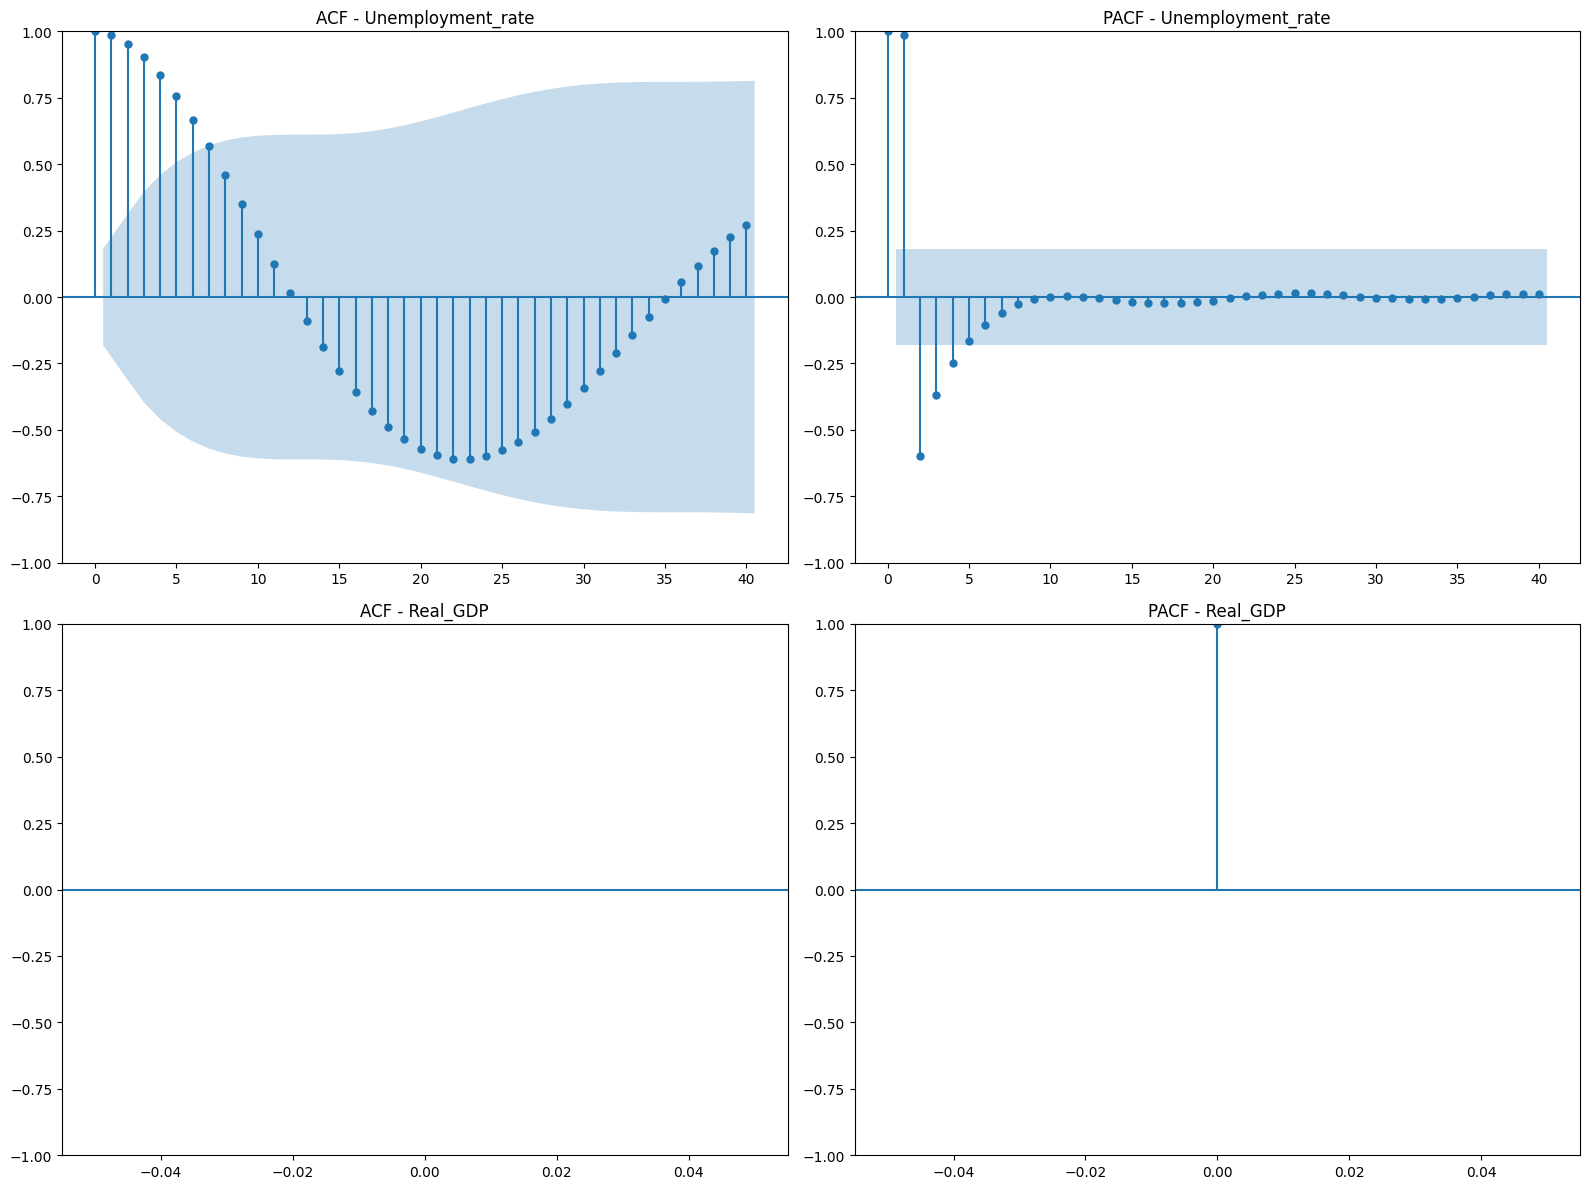

In [51]:
# Etape de préprocessing et d'affichage des fonctions ACF et PACF
country_code4 = list_random_countries[3]
country4 = PreProcessing(country_code4, df_unemployment, df_gdp)
country4.ACF_PACF_plot()

In [53]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_4 = 7  # Lags pour Unemployment_rate
lags_gdp_4 = 0  # Lags pour Real_GDP

In [54]:
# Affichage des résultats de la modélisation
country4_model = ARDLAnalysis(country_code4, df_unemployment, df_gdp, lags_ur_4, lags_gdp_4)
country4_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     490.2
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           1.93e-79
Time:                        17:14:39   Log-Likelihood:                 1120.3
No. Observations:                 106   AIC:                            -2207.
Df Residuals:                      89   BIC:                            -2161.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.461e-06   8.23e-07     -1.775      0.079    -3.1e-06    1.74e-07
Unemployment_rate      -0.0030      0.002     -1.651      0.102      -0.007       0.001
Real_GDP                1.5126      0.098     15.442      0.000       1.318       1.707
Unemployment_rate_1     0.0094      0.007      1.364      0.176      -0.004       0.023
Real_GDP_1             -0.1514      0.183     -0.827      0.411      -0.516       0.213
Unemployment_rate_2    -0.0103      0.011     -0.899      0.371      -0.033       0.012
Real_GDP_2             -0.5215      0.187     -2.784      0.007      -0.894      -0.149
Unemployment_rate_3     0.0041      0.013      0.325      0.746      -0.021       0.029
Real_GDP_3              0.2213      0.197      1.124      0.264      -0.170       0.612
Unemployment_rate_4 -6.561e-05      0.012     -0.005      0.996      -0.024       0.024
Real_GDP_4             -0.5123      0.196     -2.618      0.010      -0.901      -0.124
Unemployment_rate_5    -0.0009      0.011     -0.081      0.935      -0.022       0.020
Real_GDP_5              0.2892      0.117      2.467      0.016       0.056       0.522
Unemployment_rate_6     0.0016      0.006      0.256      0.799      -0.011       0.014
Real_GDP_6              0.1232      0.084      1.465      0.147      -0.044       0.290
Unemployment_rate_7    -0.0009      0.002     -0.547      0.585      -0.004       0.002
Real_GDP_7             -0.0842      0.047     -1.792      0.077      -0.178       0.009
==============================================================================
Omnibus:                        6.040   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                9.699
Skew:                           0.058   Prob(JB):                      0.00783
Kurtosis:                       4.477   Cond. No.                     3.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# <span style="color:green">Conclusion de la modélisation ARDL : PIB et Taux de Chômage </span><br><br>

Dans cette étude, notre objectif était de modéliser la relation entre le Produit Intérieur Brut (PIB) et le taux de chômage en utilisant le modèle AutoRegressive Distributed Lag (ARDL). Nous avons choisi une approche simplifiée en utilisant la méthode Ordinary Least Squares (OLS) pour estimer les paramètres du modèle ARDL, en prenant en compte les retards des variables afin de capturer la dynamique temporelle des données.

Les résultats obtenus révèlent plusieurs aspects intéressants de la relation entre le PIB et le taux de chômage. L'estimation des coefficients des variables explicatives, y compris les retards, offre des observations sur l'impact des variations passées du taux de chômage et du PIB sur les valeurs actuelles du PIB. Cependant, il est important de noter que certaines des variables explicatives présentent des p-values élevées, indiquant une insignifiance statistique. Cela suggère que certains coefficients ne sont pas significatifs dans la prédiction du PIB, et leur influence potentielle sur les variations du PIB est remise en question.

L'évaluation globale du modèle est représentée par le coefficient de détermination (R-squared). Le R-squared élevé suggère que le modèle explique une proportion significative de la variance observée dans le PIB en fonction du taux de chômage et de ses retards. Cette forte explication de la variance peut être interprétée comme une indication de la cointégration entre les séries, soulignant une relation à long terme entre le PIB et le taux de chômage. 

Cependant, il est crucial d'interpréter ces résultats avec prudence. L'analyse des résidus, la vérification des hypothèses du modèle, et d'autres diagnostics sont nécessaires pour assurer la robustesse des résultats. 

En conclusion, notre approche de modélisation ARDL à l'aide d'OLS offre un cadre pour comprendre la relation complexe entre le PIB et le taux de chômage tout en prenant en compte les aspects temporels. Les résultats, bien que certains coefficients ne soient pas significatifs, avec un R-squared élevé, suggèrent une cointégration significative entre les séries, renforçant l'idée d'une relation à long terme. Une interprétation minutieuse et une validation approfondie du modèle sont nécessaires pour des conclusions significatives et applicables sur le plan économique.